In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing libraries

In [2]:
import numpy as np
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop,Adam
import tensorflow as tf



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/archive.zip'

Archive:  /content/drive/MyDrive/archive.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


# Exploring the data

In [6]:
data=pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')

In [7]:
#shape of the data
data.shape

(27455, 785)

In [8]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [9]:
sorted(data.label.unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

**9 is missing ==the letter J**
So build a function that adjust the class labels

In [10]:
def adjust_class_labels(label):

    if label >= 10:
        label -= 1

    return label

# Adjusting the class labels (training data)
data["label"] = data["label"].apply(adjust_class_labels)

In [11]:
np.unique(data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

**#Checking for missing values**

In [12]:
data.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

# **plotting some images**

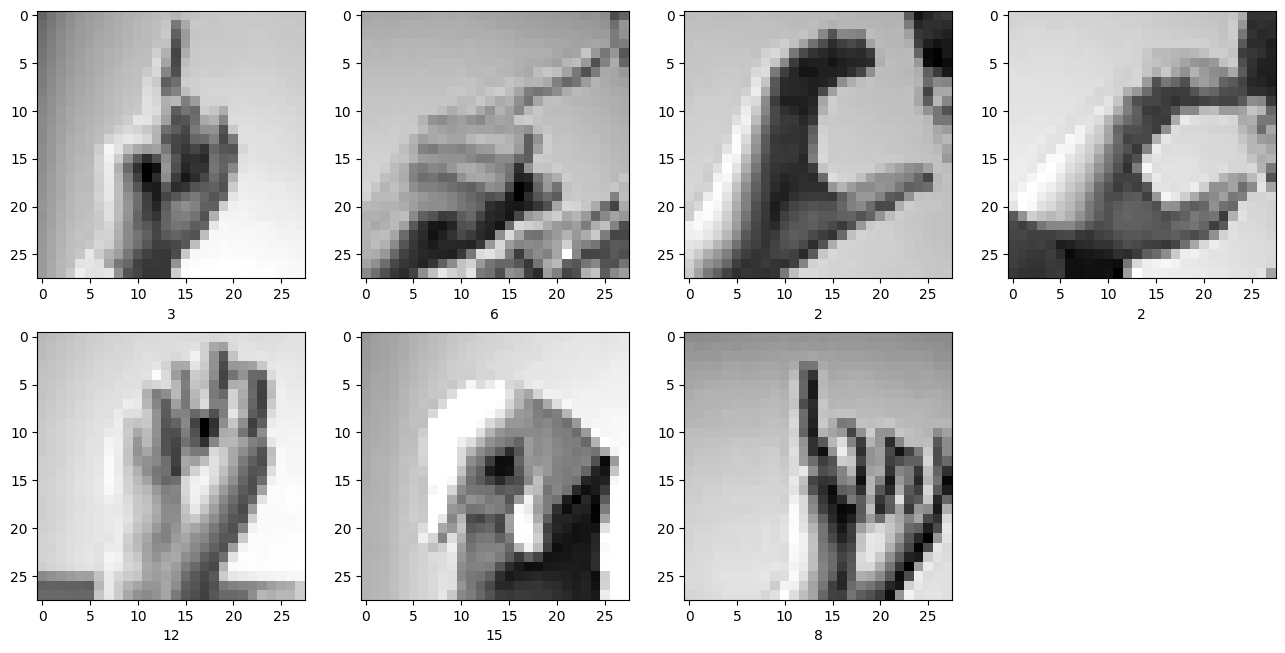

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
images=data.drop('label',axis=1).values
plt.figure(figsize=(16,16))
for i in range(7):
    img=images[i].reshape(28,28)
    fig = plt.subplot(4,4,i+1)
    plt.xlabel(data['label'][i])
    plt.imshow(img, cmap='gray')



# Processing the data

In [14]:
#convertir data to array

x=data.drop('label',axis=1)
y=data.label

#splitting the data using 80% of data as training data
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2,shuffle=True, random_state=2)


#reshape the data to fit in the model as size of input 28*28**

X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)

#scaling
X_train=X_train/255.0
X_val=X_val/255.0


#convert the lables to categorical data using one-hot encoding
y_train=to_categorical(y_train)

y_val=to_categorical(y_val)

In [15]:
X_val.shape

(5491, 28, 28, 1)

# Bulidng our network : CNN model
**Fisrt Approach**

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(24, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [19]:
#compile the model
        #choice of optimizer RMSProp
    # decay
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


batch_size=30
epochs=10

# Train your model using augmented data/
history=model.fit(X_train,y_train, steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=epochs,validation_data=(X_val, y_val),verbose=2)



Epoch 1/10
732/732 - 35s - loss: 0.8634 - accuracy: 0.7375 - val_loss: 0.0964 - val_accuracy: 0.9667 - 35s/epoch - 48ms/step
Epoch 2/10
732/732 - 33s - loss: 0.0563 - accuracy: 0.9836 - val_loss: 0.0028 - val_accuracy: 0.9996 - 33s/epoch - 45ms/step
Epoch 3/10
732/732 - 33s - loss: 0.0145 - accuracy: 0.9959 - val_loss: 7.8815e-04 - val_accuracy: 1.0000 - 33s/epoch - 45ms/step
Epoch 4/10
732/732 - 33s - loss: 0.0076 - accuracy: 0.9978 - val_loss: 1.1394e-04 - val_accuracy: 1.0000 - 33s/epoch - 45ms/step
Epoch 5/10
732/732 - 34s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 6.4617e-05 - val_accuracy: 1.0000 - 34s/epoch - 47ms/step
Epoch 6/10
732/732 - 34s - loss: 0.0042 - accuracy: 0.9986 - val_loss: 2.1676e-05 - val_accuracy: 1.0000 - 34s/epoch - 46ms/step
Epoch 7/10
732/732 - 33s - loss: 0.0020 - accuracy: 0.9993 - val_loss: 1.4129e-05 - val_accuracy: 1.0000 - 33s/epoch - 45ms/step
Epoch 8/10
732/732 - 35s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 1.7471e-05 - val_accuracy: 1.0000 

732/732 - 22s - loss: 5.4037e-04 - accuracy: 0.9998 - val_loss: 3.0417e-05 - val_accuracy: 1.0000 - 22s/epoch - 30ms/step


# Evaluation of the performance #try1

In [20]:

test=pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')

y_test=test["label"].apply(adjust_class_labels)


test=test.drop('label',axis=1)
test=test.values.reshape((-1,28, 28,1))

test=test/255
y_test=to_categorical(y_test)



acc = model.evaluate(test,y_test, steps=50)

50/50 [==============================] - 3s 53ms/step - loss: 0.5792 - accuracy: 0.9183


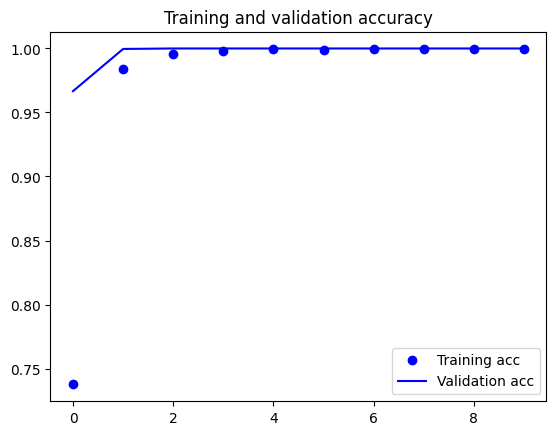

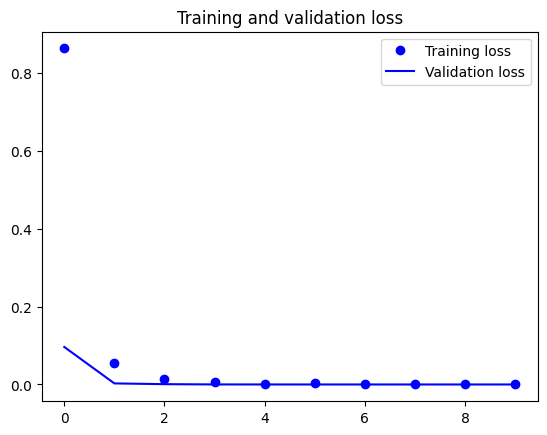

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Clearly this is overfitting ,the model needs more parameteres cuz the data is large**

In [22]:
import joblib
joblib.dump(model, 'model_try1.pkl')

['model_try1.pkl']

# #Try2 : adding more layers


In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(24, activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 64)          51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 128)        

In [26]:
#compile the model
        #choice of optimizer RMSProp
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


batch_size=100
epochs=10

# Train your model using augmented data/
history=model.fit(X_train,y_train, steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=epochs,validation_data=(X_val, y_val),verbose=2)



Epoch 1/10
219/219 - 41s - loss: 2.5040 - accuracy: 0.1987 - val_loss: 1.3488 - val_accuracy: 0.5433 - 41s/epoch - 186ms/step
Epoch 2/10
219/219 - 44s - loss: 0.8934 - accuracy: 0.6875 - val_loss: 0.2113 - val_accuracy: 0.9261 - 44s/epoch - 199ms/step
Epoch 3/10
219/219 - 40s - loss: 0.2181 - accuracy: 0.9281 - val_loss: 0.0107 - val_accuracy: 1.0000 - 40s/epoch - 181ms/step
Epoch 4/10
219/219 - 40s - loss: 0.0642 - accuracy: 0.9831 - val_loss: 0.0417 - val_accuracy: 0.9849 - 40s/epoch - 182ms/step
Epoch 5/10
219/219 - 43s - loss: 0.0255 - accuracy: 0.9935 - val_loss: 0.0027 - val_accuracy: 0.9987 - 43s/epoch - 195ms/step
Epoch 6/10
219/219 - 39s - loss: 0.0240 - accuracy: 0.9942 - val_loss: 2.4653e-04 - val_accuracy: 1.0000 - 39s/epoch - 177ms/step
Epoch 7/10
219/219 - 39s - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0011 - val_accuracy: 0.9998 - 39s/epoch - 177ms/step
Epoch 8/10
219/219 - 42s - loss: 0.0104 - accuracy: 0.9974 - val_loss: 0.0014 - val_accuracy: 0.9995 - 42s/epoch -

219/219 - 38s - loss: 0.0071 - accuracy: 0.9982 - val_loss: 1.0777e-06 - val_accuracy: 1.0000 - 38s/epoch - 172ms/step


In [27]:
#saving the mdoel
model.save('try_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation 94.55% , on the data test

In [28]:
test_loss, test_acc = model.evaluate(test,y_test, steps=50)

50/50 [==============================] - 4s 86ms/step - loss: 0.1625 - accuracy: 0.9695


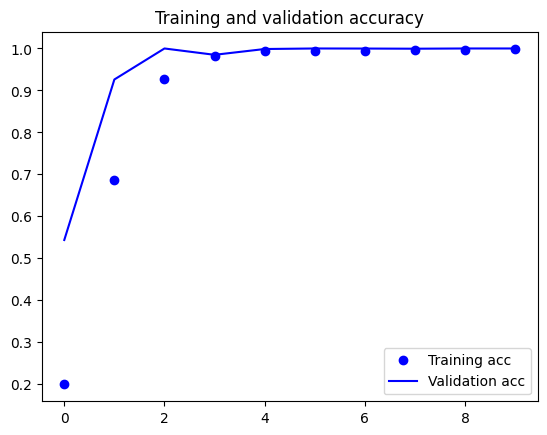

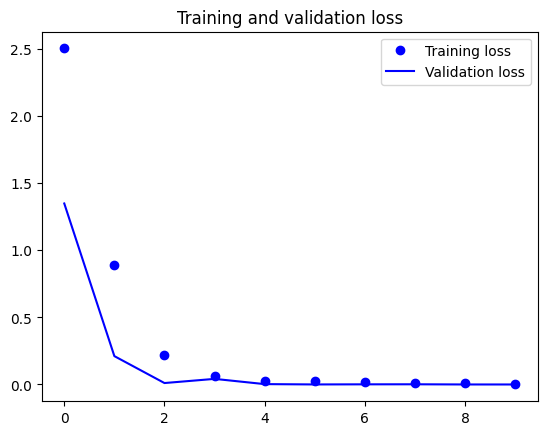

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**#this looks better when i modify the layers**

# #Try3 : technique to avoid overfitting
1.            **Data augmentation**

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(24, activation='softmax'))

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

batch_size = 30
augmented_data_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Apply the EarlyStopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train your model using augmented data
history = model.fit(augmented_data_generator,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=20,
                    validation_data=(X_val, y_val),  # Corrected here
                    callbacks=[early_stopping],
                    verbose=2)


Epoch 1/20
732/732 - 46s - loss: 2.8036 - accuracy: 0.1372 - val_loss: 1.8721 - val_accuracy: 0.4103 - 46s/epoch - 62ms/step
Epoch 2/20
732/732 - 40s - loss: 2.1047 - accuracy: 0.3217 - val_loss: 1.3316 - val_accuracy: 0.5680 - 40s/epoch - 55ms/step
Epoch 3/20
732/732 - 40s - loss: 1.7446 - accuracy: 0.4299 - val_loss: 1.1532 - val_accuracy: 0.6070 - 40s/epoch - 55ms/step
Epoch 4/20
732/732 - 43s - loss: 1.5166 - accuracy: 0.4982 - val_loss: 0.7542 - val_accuracy: 0.7815 - 43s/epoch - 59ms/step
Epoch 5/20
732/732 - 42s - loss: 1.3474 - accuracy: 0.5535 - val_loss: 0.5889 - val_accuracy: 0.8188 - 42s/epoch - 57ms/step
Epoch 6/20
732/732 - 42s - loss: 1.2086 - accuracy: 0.5957 - val_loss: 0.5112 - val_accuracy: 0.8436 - 42s/epoch - 58ms/step
Epoch 7/20
732/732 - 40s - loss: 1.1102 - accuracy: 0.6329 - val_loss: 0.4152 - val_accuracy: 0.8783 - 40s/epoch - 55ms/step
Epoch 8/20
732/732 - 40s - loss: 1.0411 - accuracy: 0.6510 - val_loss: 0.3536 - val_accuracy: 0.8993 - 40s/epoch - 55ms/step


In [33]:
#saving the mdoel
joblib.dump(model, 'model_try4.pkl')

['model_try4.pkl']

# Evaluation on Test Data Acc 95%

In [35]:
test=pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')

y_test=test["label"].apply(adjust_class_labels)


test=test.drop('label',axis=1)
test=test.values.reshape((-1,28, 28,1))

test=test/255
y_test=to_categorical(y_test)



acc = model.evaluate(test,y_test, steps=50)

50/50 [==============================] - 2s 36ms/step - loss: 0.1968 - accuracy: 0.9373


# plotting loss/accur on valid/train data

**we can see that we manage the problem of overfitting**

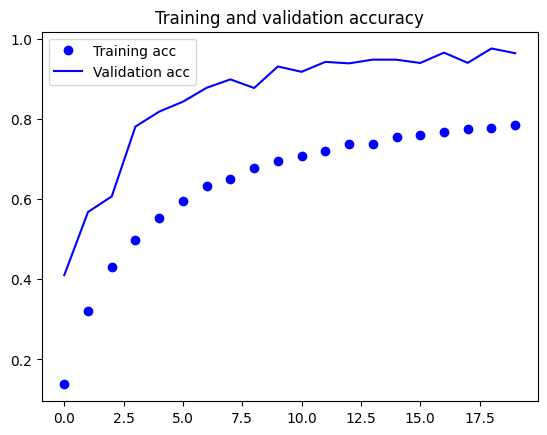

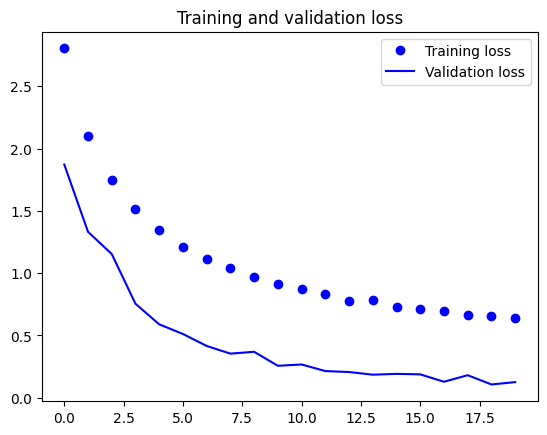

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>

Saved to photo.jpg


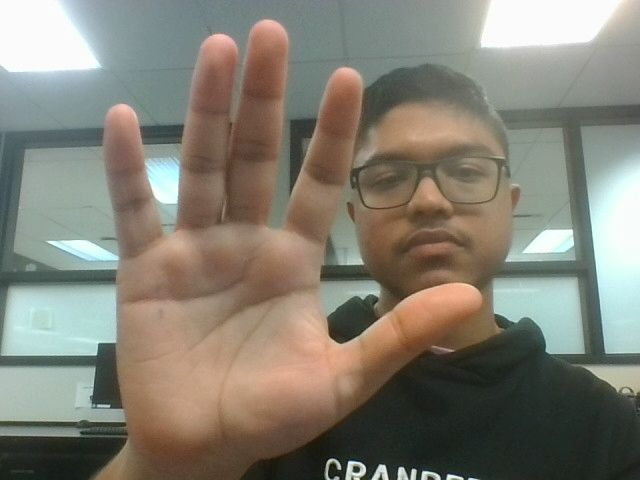

In [40]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [39]:
from keras.models import load_model
model = load_model('/content/try_model.h5')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [94]:
import cv2

img = Image.open(r"photo.jpg").convert('L')

# image = cv2.imread('photo.jpg')
# image=image.resize((28,28))
# fig = plt.subplot(4,4,i+1)
# plt.imshow(image, cmap='gray')
# #plt.imshow(im2)

# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# img = plt.imshow(image, cmap='gray')

filter = ImageEnhance.Color(img)
filter.enhance(0)
print(img)



<PIL.Image.Image image mode=L size=640x480 at 0x790DB5C7D2A0>


In [105]:
img = Image.open("photo.jpg")
img_data = img.getdata()

lst=[]
for i in img_data:
    lst.append(i[0]*0.2125+i[1]*0.7174+i[2]*0.0721)

new_img = Image.new("L", img.size)
new_img.putdata(lst)
print(new_img)

plt.show(new_img)

<PIL.Image.Image image mode=L size=640x480 at 0x790D7F230340>


In [123]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf

def preprocess_image(img, best_model):
    labels = ['1','10','2','3','4','5','6','7','8','9','A','B','Blank','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','space']

    # Resize the image to (28, 28)
    img = img.resize((28, 28))

    # Convert the image to grayscale
    img_array = np.array(img.convert('L'))

    # Expand dimensions to match model input shape
    img_batch = np.expand_dims(img_array, axis=0)

    # Preprocess the image for the model
    processed_image = tf.keras.applications.resnet50.preprocess_input(img_batch)

    # Make predictions using the model
    predictions = best_model.predict(processed_image)

    # Get the predicted label
    max_index = np.argmax(predictions)
    predicted_label = labels[max_index]

    return predicted_label

# Load the image using PIL
img_path = 'photo.jpg'
img = Image.open(img_path)

# Call the preprocess_image function
letter = preprocess_image(img, model)
print(type(letter))
print(f'The image is predicted as {letter}')


1/1 [==============================] - 0s 51ms/step
<class 'str'>
The image is predicted as 7
